# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

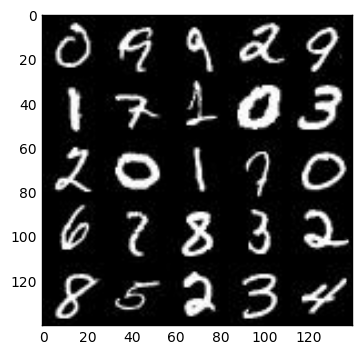

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

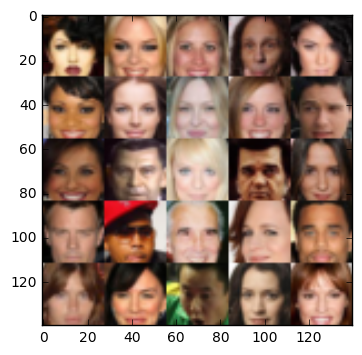

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]


    input_real, input_z, learn_rate = model_inputs(image_width, image_height, output_dim, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, output_dim)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                #Rescaling images
                batch_images *= 2.0

                # Random Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Optimizing
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 2nd
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                # Optimize Generator again 3rd
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Determine losses and print
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, output_dim, data_image_mode)
        
    return None
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch# 10... Discriminator Loss: 3.7213... Generator Loss: 0.0381
Epoch 1/2 Batch# 20... Discriminator Loss: 2.0341... Generator Loss: 0.4926
Epoch 1/2 Batch# 30... Discriminator Loss: 1.7026... Generator Loss: 0.5061
Epoch 1/2 Batch# 40... Discriminator Loss: 1.9897... Generator Loss: 0.2402
Epoch 1/2 Batch# 50... Discriminator Loss: 1.8142... Generator Loss: 0.4847
Epoch 1/2 Batch# 60... Discriminator Loss: 1.7449... Generator Loss: 0.6005
Epoch 1/2 Batch# 70... Discriminator Loss: 1.6835... Generator Loss: 0.4408
Epoch 1/2 Batch# 80... Discriminator Loss: 1.7247... Generator Loss: 0.4738
Epoch 1/2 Batch# 90... Discriminator Loss: 1.7315... Generator Loss: 0.4018
Epoch 1/2 Batch# 100... Discriminator Loss: 1.9146... Generator Loss: 0.2687


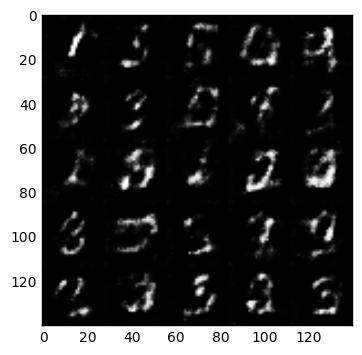

Epoch 1/2 Batch# 110... Discriminator Loss: 1.5922... Generator Loss: 0.9255
Epoch 1/2 Batch# 120... Discriminator Loss: 1.6797... Generator Loss: 0.4103
Epoch 1/2 Batch# 130... Discriminator Loss: 1.5977... Generator Loss: 0.4097
Epoch 1/2 Batch# 140... Discriminator Loss: 1.9642... Generator Loss: 0.2257
Epoch 1/2 Batch# 150... Discriminator Loss: 1.4374... Generator Loss: 0.4770
Epoch 1/2 Batch# 160... Discriminator Loss: 1.8705... Generator Loss: 0.2586
Epoch 1/2 Batch# 170... Discriminator Loss: 1.5822... Generator Loss: 0.3677
Epoch 1/2 Batch# 180... Discriminator Loss: 1.6308... Generator Loss: 0.7301
Epoch 1/2 Batch# 190... Discriminator Loss: 1.6241... Generator Loss: 1.0488
Epoch 1/2 Batch# 200... Discriminator Loss: 1.5258... Generator Loss: 0.4165


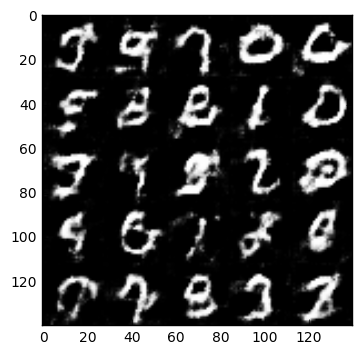

Epoch 1/2 Batch# 210... Discriminator Loss: 1.4442... Generator Loss: 0.8688
Epoch 1/2 Batch# 220... Discriminator Loss: 1.7348... Generator Loss: 0.3187
Epoch 1/2 Batch# 230... Discriminator Loss: 1.5369... Generator Loss: 0.6808
Epoch 1/2 Batch# 240... Discriminator Loss: 1.4544... Generator Loss: 0.6915
Epoch 1/2 Batch# 250... Discriminator Loss: 1.3258... Generator Loss: 0.6531
Epoch 1/2 Batch# 260... Discriminator Loss: 1.5840... Generator Loss: 0.3634
Epoch 1/2 Batch# 270... Discriminator Loss: 1.7970... Generator Loss: 0.2409
Epoch 1/2 Batch# 280... Discriminator Loss: 1.5237... Generator Loss: 0.8793
Epoch 1/2 Batch# 290... Discriminator Loss: 1.4249... Generator Loss: 0.5338
Epoch 1/2 Batch# 300... Discriminator Loss: 1.4343... Generator Loss: 0.7253


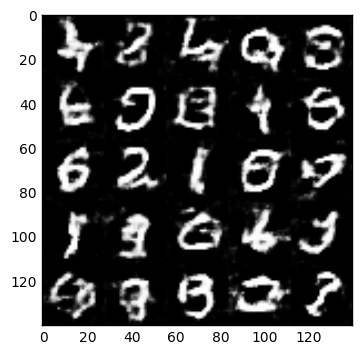

Epoch 1/2 Batch# 310... Discriminator Loss: 1.4811... Generator Loss: 0.8435
Epoch 1/2 Batch# 320... Discriminator Loss: 1.7636... Generator Loss: 0.3011
Epoch 1/2 Batch# 330... Discriminator Loss: 1.7036... Generator Loss: 0.2772
Epoch 1/2 Batch# 340... Discriminator Loss: 1.5261... Generator Loss: 0.3779
Epoch 1/2 Batch# 350... Discriminator Loss: 1.3630... Generator Loss: 0.6074
Epoch 1/2 Batch# 360... Discriminator Loss: 1.3954... Generator Loss: 0.6558
Epoch 1/2 Batch# 370... Discriminator Loss: 1.6496... Generator Loss: 0.3109
Epoch 1/2 Batch# 380... Discriminator Loss: 1.4409... Generator Loss: 1.3314
Epoch 1/2 Batch# 390... Discriminator Loss: 1.5376... Generator Loss: 0.3622
Epoch 1/2 Batch# 400... Discriminator Loss: 1.5102... Generator Loss: 0.4244


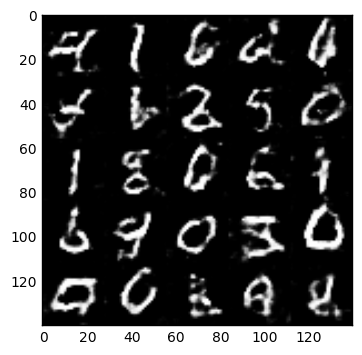

Epoch 1/2 Batch# 410... Discriminator Loss: 1.5317... Generator Loss: 0.3332
Epoch 1/2 Batch# 420... Discriminator Loss: 1.3635... Generator Loss: 1.0431
Epoch 1/2 Batch# 430... Discriminator Loss: 1.3028... Generator Loss: 0.5648
Epoch 1/2 Batch# 440... Discriminator Loss: 1.4491... Generator Loss: 0.4306
Epoch 1/2 Batch# 450... Discriminator Loss: 1.2014... Generator Loss: 0.8914
Epoch 1/2 Batch# 460... Discriminator Loss: 1.6621... Generator Loss: 1.7084
Epoch 1/2 Batch# 570... Discriminator Loss: 1.2505... Generator Loss: 1.5120
Epoch 1/2 Batch# 580... Discriminator Loss: 1.7919... Generator Loss: 0.2409
Epoch 1/2 Batch# 590... Discriminator Loss: 0.9179... Generator Loss: 1.1327
Epoch 1/2 Batch# 600... Discriminator Loss: 1.2117... Generator Loss: 0.6276


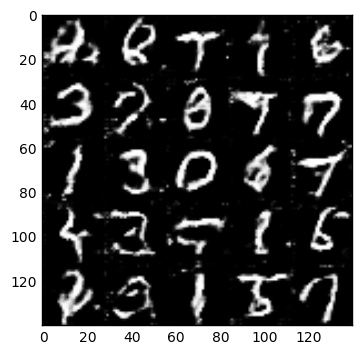

Epoch 1/2 Batch# 610... Discriminator Loss: 1.2713... Generator Loss: 0.5573
Epoch 1/2 Batch# 620... Discriminator Loss: 1.5906... Generator Loss: 0.3393
Epoch 1/2 Batch# 630... Discriminator Loss: 1.0210... Generator Loss: 1.0383
Epoch 1/2 Batch# 640... Discriminator Loss: 1.4446... Generator Loss: 1.3912
Epoch 1/2 Batch# 650... Discriminator Loss: 1.3171... Generator Loss: 0.4786
Epoch 1/2 Batch# 660... Discriminator Loss: 1.0177... Generator Loss: 1.0674
Epoch 1/2 Batch# 670... Discriminator Loss: 1.1293... Generator Loss: 1.3926
Epoch 1/2 Batch# 680... Discriminator Loss: 1.1544... Generator Loss: 0.7858
Epoch 1/2 Batch# 690... Discriminator Loss: 1.2236... Generator Loss: 0.4831
Epoch 1/2 Batch# 700... Discriminator Loss: 1.0491... Generator Loss: 0.8299


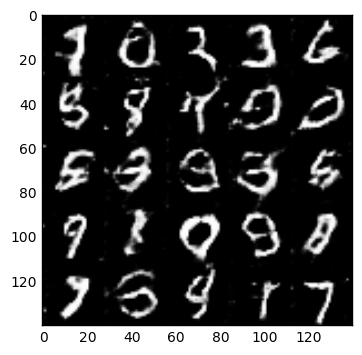

Epoch 1/2 Batch# 710... Discriminator Loss: 1.0626... Generator Loss: 0.6054
Epoch 1/2 Batch# 720... Discriminator Loss: 1.3576... Generator Loss: 0.3763
Epoch 1/2 Batch# 730... Discriminator Loss: 1.1525... Generator Loss: 0.5956
Epoch 1/2 Batch# 740... Discriminator Loss: 1.5535... Generator Loss: 1.5263
Epoch 1/2 Batch# 750... Discriminator Loss: 1.1607... Generator Loss: 0.7284
Epoch 1/2 Batch# 760... Discriminator Loss: 1.7279... Generator Loss: 1.9944
Epoch 1/2 Batch# 770... Discriminator Loss: 0.9280... Generator Loss: 1.5226
Epoch 1/2 Batch# 780... Discriminator Loss: 1.0631... Generator Loss: 0.7595
Epoch 1/2 Batch# 790... Discriminator Loss: 0.9898... Generator Loss: 1.7077
Epoch 1/2 Batch# 800... Discriminator Loss: 1.0787... Generator Loss: 0.7063


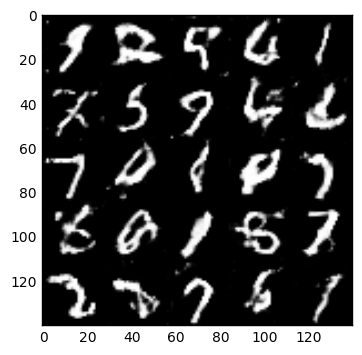

Epoch 1/2 Batch# 810... Discriminator Loss: 0.9517... Generator Loss: 0.7742
Epoch 1/2 Batch# 820... Discriminator Loss: 1.2207... Generator Loss: 1.4457
Epoch 1/2 Batch# 830... Discriminator Loss: 0.9645... Generator Loss: 1.4090
Epoch 1/2 Batch# 840... Discriminator Loss: 0.9930... Generator Loss: 0.6208
Epoch 1/2 Batch# 850... Discriminator Loss: 2.3133... Generator Loss: 0.2653
Epoch 1/2 Batch# 860... Discriminator Loss: 1.1809... Generator Loss: 0.6519
Epoch 1/2 Batch# 870... Discriminator Loss: 1.1343... Generator Loss: 0.6568
Epoch 1/2 Batch# 880... Discriminator Loss: 0.9659... Generator Loss: 1.0650
Epoch 1/2 Batch# 890... Discriminator Loss: 0.9069... Generator Loss: 1.1607
Epoch 1/2 Batch# 900... Discriminator Loss: 1.4379... Generator Loss: 0.4183


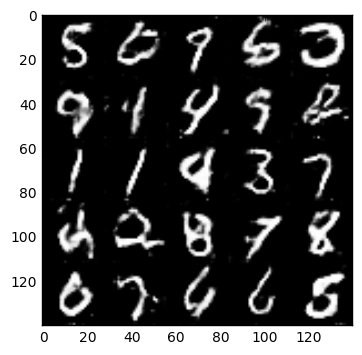

Epoch 1/2 Batch# 910... Discriminator Loss: 1.9757... Generator Loss: 0.2745
Epoch 1/2 Batch# 920... Discriminator Loss: 0.6652... Generator Loss: 1.1155
Epoch 1/2 Batch# 930... Discriminator Loss: 0.5795... Generator Loss: 1.2921
Epoch 2/2 Batch# 10... Discriminator Loss: 0.8437... Generator Loss: 1.5143
Epoch 2/2 Batch# 20... Discriminator Loss: 1.1372... Generator Loss: 0.6318
Epoch 2/2 Batch# 30... Discriminator Loss: 1.1903... Generator Loss: 0.4792
Epoch 2/2 Batch# 40... Discriminator Loss: 1.3274... Generator Loss: 0.5065
Epoch 2/2 Batch# 50... Discriminator Loss: 1.9010... Generator Loss: 0.2025
Epoch 2/2 Batch# 60... Discriminator Loss: 0.7190... Generator Loss: 1.1569
Epoch 2/2 Batch# 70... Discriminator Loss: 0.8927... Generator Loss: 0.8214
Epoch 2/2 Batch# 80... Discriminator Loss: 0.9151... Generator Loss: 0.7647
Epoch 2/2 Batch# 90... Discriminator Loss: 0.4396... Generator Loss: 1.3635
Epoch 2/2 Batch# 100... Discriminator Loss: 1.0862... Generator Loss: 1.0677


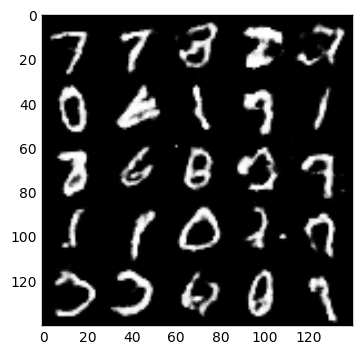

Epoch 2/2 Batch# 110... Discriminator Loss: 0.9375... Generator Loss: 1.4652
Epoch 2/2 Batch# 120... Discriminator Loss: 0.7824... Generator Loss: 1.2185
Epoch 2/2 Batch# 130... Discriminator Loss: 0.6235... Generator Loss: 2.4169
Epoch 2/2 Batch# 140... Discriminator Loss: 0.5401... Generator Loss: 1.1992
Epoch 2/2 Batch# 150... Discriminator Loss: 0.3717... Generator Loss: 1.7741
Epoch 2/2 Batch# 160... Discriminator Loss: 0.3480... Generator Loss: 1.4399
Epoch 2/2 Batch# 170... Discriminator Loss: 1.8421... Generator Loss: 0.4849
Epoch 2/2 Batch# 180... Discriminator Loss: 0.7292... Generator Loss: 0.9913
Epoch 2/2 Batch# 190... Discriminator Loss: 0.8163... Generator Loss: 2.0020
Epoch 2/2 Batch# 200... Discriminator Loss: 1.1144... Generator Loss: 0.5807


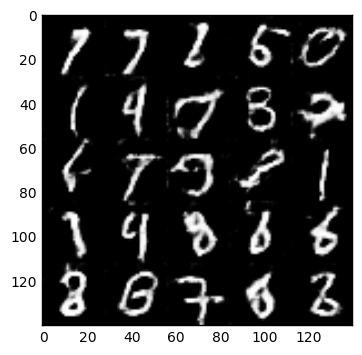

Epoch 2/2 Batch# 210... Discriminator Loss: 1.2080... Generator Loss: 0.5929
Epoch 2/2 Batch# 220... Discriminator Loss: 0.4903... Generator Loss: 1.8583
Epoch 2/2 Batch# 230... Discriminator Loss: 0.9748... Generator Loss: 0.7438
Epoch 2/2 Batch# 240... Discriminator Loss: 0.3839... Generator Loss: 1.8855
Epoch 2/2 Batch# 250... Discriminator Loss: 0.4328... Generator Loss: 1.7155
Epoch 2/2 Batch# 260... Discriminator Loss: 0.7637... Generator Loss: 0.9126
Epoch 2/2 Batch# 270... Discriminator Loss: 0.4107... Generator Loss: 1.6747
Epoch 2/2 Batch# 280... Discriminator Loss: 1.8561... Generator Loss: 0.2172
Epoch 2/2 Batch# 290... Discriminator Loss: 0.6429... Generator Loss: 1.3145
Epoch 2/2 Batch# 300... Discriminator Loss: 0.6229... Generator Loss: 1.2661


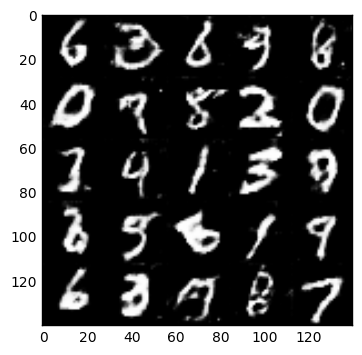

Epoch 2/2 Batch# 310... Discriminator Loss: 0.5868... Generator Loss: 1.3214
Epoch 2/2 Batch# 320... Discriminator Loss: 0.6612... Generator Loss: 1.5085
Epoch 2/2 Batch# 330... Discriminator Loss: 0.3753... Generator Loss: 1.8246
Epoch 2/2 Batch# 340... Discriminator Loss: 2.3806... Generator Loss: 5.2323
Epoch 2/2 Batch# 350... Discriminator Loss: 1.5601... Generator Loss: 0.4902
Epoch 2/2 Batch# 360... Discriminator Loss: 0.4800... Generator Loss: 1.5604
Epoch 2/2 Batch# 370... Discriminator Loss: 0.7150... Generator Loss: 1.1348
Epoch 2/2 Batch# 380... Discriminator Loss: 3.5151... Generator Loss: 6.0509
Epoch 2/2 Batch# 390... Discriminator Loss: 0.7129... Generator Loss: 1.2467
Epoch 2/2 Batch# 400... Discriminator Loss: 1.0601... Generator Loss: 0.6895


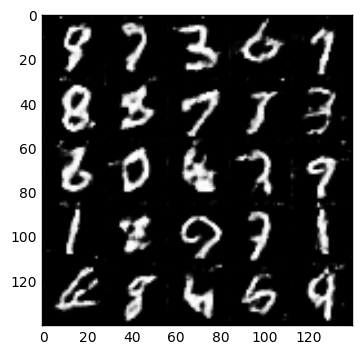

Epoch 2/2 Batch# 410... Discriminator Loss: 1.0717... Generator Loss: 0.8319
Epoch 2/2 Batch# 420... Discriminator Loss: 0.5123... Generator Loss: 1.5550
Epoch 2/2 Batch# 430... Discriminator Loss: 0.3120... Generator Loss: 1.8875
Epoch 2/2 Batch# 440... Discriminator Loss: 0.3687... Generator Loss: 1.6517
Epoch 2/2 Batch# 450... Discriminator Loss: 0.6372... Generator Loss: 1.3467
Epoch 2/2 Batch# 460... Discriminator Loss: 0.4443... Generator Loss: 1.3127
Epoch 2/2 Batch# 470... Discriminator Loss: 0.6065... Generator Loss: 1.5652
Epoch 2/2 Batch# 480... Discriminator Loss: 0.3180... Generator Loss: 1.8836
Epoch 2/2 Batch# 490... Discriminator Loss: 0.6344... Generator Loss: 1.5864
Epoch 2/2 Batch# 500... Discriminator Loss: 0.2542... Generator Loss: 2.0951


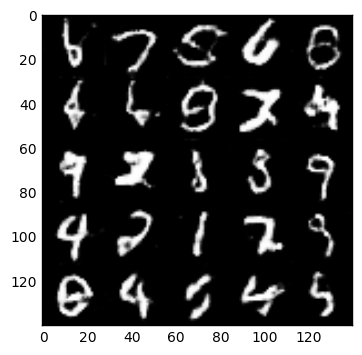

Epoch 2/2 Batch# 510... Discriminator Loss: 0.2281... Generator Loss: 2.0978
Epoch 2/2 Batch# 520... Discriminator Loss: 0.1733... Generator Loss: 2.5036
Epoch 2/2 Batch# 530... Discriminator Loss: 0.1812... Generator Loss: 2.5072
Epoch 2/2 Batch# 540... Discriminator Loss: 0.2660... Generator Loss: 2.3717
Epoch 2/2 Batch# 550... Discriminator Loss: 0.4166... Generator Loss: 1.4664
Epoch 2/2 Batch# 560... Discriminator Loss: 4.4652... Generator Loss: 5.8416
Epoch 2/2 Batch# 570... Discriminator Loss: 0.6387... Generator Loss: 2.0321
Epoch 2/2 Batch# 580... Discriminator Loss: 0.4721... Generator Loss: 1.6725
Epoch 2/2 Batch# 590... Discriminator Loss: 0.5143... Generator Loss: 1.5353
Epoch 2/2 Batch# 600... Discriminator Loss: 0.3631... Generator Loss: 2.4704


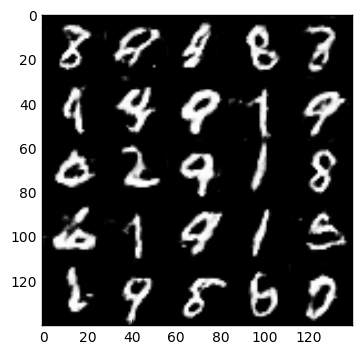

Epoch 2/2 Batch# 610... Discriminator Loss: 0.5815... Generator Loss: 1.2010
Epoch 2/2 Batch# 620... Discriminator Loss: 0.2774... Generator Loss: 1.6151
Epoch 2/2 Batch# 630... Discriminator Loss: 0.2347... Generator Loss: 2.2411
Epoch 2/2 Batch# 640... Discriminator Loss: 0.2461... Generator Loss: 1.8192
Epoch 2/2 Batch# 650... Discriminator Loss: 0.5666... Generator Loss: 1.0154
Epoch 2/2 Batch# 660... Discriminator Loss: 0.2708... Generator Loss: 2.4216
Epoch 2/2 Batch# 670... Discriminator Loss: 0.3909... Generator Loss: 1.3989
Epoch 2/2 Batch# 680... Discriminator Loss: 0.5049... Generator Loss: 2.0076
Epoch 2/2 Batch# 690... Discriminator Loss: 0.1835... Generator Loss: 2.2581
Epoch 2/2 Batch# 700... Discriminator Loss: 0.2883... Generator Loss: 1.9942


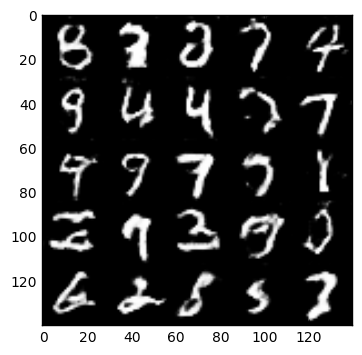

Epoch 2/2 Batch# 710... Discriminator Loss: 0.2964... Generator Loss: 2.3669
Epoch 2/2 Batch# 720... Discriminator Loss: 0.5665... Generator Loss: 3.1342
Epoch 2/2 Batch# 730... Discriminator Loss: 0.5872... Generator Loss: 2.0051
Epoch 2/2 Batch# 740... Discriminator Loss: 0.7356... Generator Loss: 0.7577
Epoch 2/2 Batch# 750... Discriminator Loss: 0.4487... Generator Loss: 2.1231
Epoch 2/2 Batch# 760... Discriminator Loss: 0.4568... Generator Loss: 1.7087
Epoch 2/2 Batch# 770... Discriminator Loss: 0.3081... Generator Loss: 1.4740
Epoch 2/2 Batch# 780... Discriminator Loss: 0.5749... Generator Loss: 0.9556
Epoch 2/2 Batch# 790... Discriminator Loss: 0.1413... Generator Loss: 3.1360
Epoch 2/2 Batch# 800... Discriminator Loss: 0.2621... Generator Loss: 1.8410


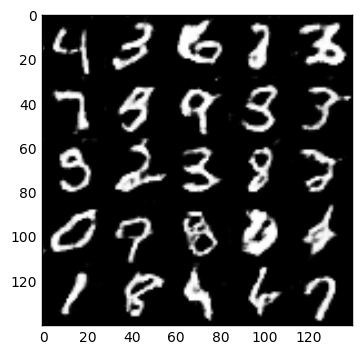

Epoch 2/2 Batch# 810... Discriminator Loss: 0.2607... Generator Loss: 2.3393
Epoch 2/2 Batch# 820... Discriminator Loss: 0.1726... Generator Loss: 2.6625
Epoch 2/2 Batch# 830... Discriminator Loss: 1.4320... Generator Loss: 2.3459
Epoch 2/2 Batch# 840... Discriminator Loss: 0.7827... Generator Loss: 1.0841
Epoch 2/2 Batch# 850... Discriminator Loss: 1.4354... Generator Loss: 0.4463
Epoch 2/2 Batch# 860... Discriminator Loss: 0.5385... Generator Loss: 1.2840
Epoch 2/2 Batch# 870... Discriminator Loss: 0.4081... Generator Loss: 1.5379
Epoch 2/2 Batch# 880... Discriminator Loss: 0.4504... Generator Loss: 1.5753
Epoch 2/2 Batch# 890... Discriminator Loss: 0.4160... Generator Loss: 1.8349
Epoch 2/2 Batch# 900... Discriminator Loss: 0.3771... Generator Loss: 1.7822


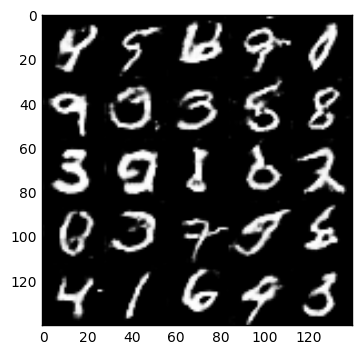

Epoch 2/2 Batch# 910... Discriminator Loss: 1.1935... Generator Loss: 0.6415
Epoch 2/2 Batch# 920... Discriminator Loss: 0.2841... Generator Loss: 2.4306
Epoch 2/2 Batch# 930... Discriminator Loss: 0.6374... Generator Loss: 1.2557


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 1.2065... Generator Loss: 0.9321
Epoch 1/1 Batch# 20... Discriminator Loss: 1.0021... Generator Loss: 1.7481
Epoch 1/1 Batch# 30... Discriminator Loss: 1.1905... Generator Loss: 1.0931
Epoch 1/1 Batch# 40... Discriminator Loss: 1.0020... Generator Loss: 0.8882
Epoch 1/1 Batch# 50... Discriminator Loss: 1.1781... Generator Loss: 1.7726
Epoch 1/1 Batch# 60... Discriminator Loss: 1.4968... Generator Loss: 0.3723
Epoch 1/1 Batch# 70... Discriminator Loss: 1.0667... Generator Loss: 1.3846
Epoch 1/1 Batch# 80... Discriminator Loss: 1.0396... Generator Loss: 0.9008
Epoch 1/1 Batch# 90... Discriminator Loss: 1.5490... Generator Loss: 0.3323
Epoch 1/1 Batch# 100... Discriminator Loss: 1.0907... Generator Loss: 1.1953


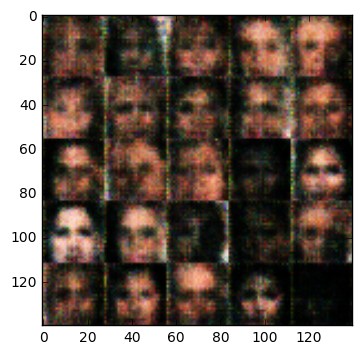

Epoch 1/1 Batch# 110... Discriminator Loss: 1.3891... Generator Loss: 0.9270
Epoch 1/1 Batch# 120... Discriminator Loss: 1.4787... Generator Loss: 0.7344
Epoch 1/1 Batch# 130... Discriminator Loss: 1.5729... Generator Loss: 0.4491
Epoch 1/1 Batch# 140... Discriminator Loss: 1.5951... Generator Loss: 0.9374
Epoch 1/1 Batch# 150... Discriminator Loss: 1.8894... Generator Loss: 0.3591
Epoch 1/1 Batch# 160... Discriminator Loss: 1.7155... Generator Loss: 0.5675
Epoch 1/1 Batch# 170... Discriminator Loss: 1.6358... Generator Loss: 0.4883
Epoch 1/1 Batch# 180... Discriminator Loss: 1.6750... Generator Loss: 0.6274
Epoch 1/1 Batch# 190... Discriminator Loss: 1.5377... Generator Loss: 0.5423
Epoch 1/1 Batch# 200... Discriminator Loss: 1.6502... Generator Loss: 0.6522


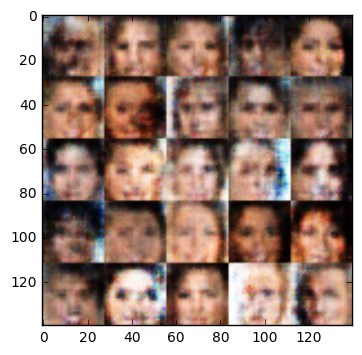

Epoch 1/1 Batch# 210... Discriminator Loss: 1.4946... Generator Loss: 0.6364
Epoch 1/1 Batch# 220... Discriminator Loss: 1.5460... Generator Loss: 0.6309
Epoch 1/1 Batch# 230... Discriminator Loss: 1.5430... Generator Loss: 0.6242
Epoch 1/1 Batch# 240... Discriminator Loss: 1.6480... Generator Loss: 0.5480
Epoch 1/1 Batch# 250... Discriminator Loss: 1.5074... Generator Loss: 0.5903
Epoch 1/1 Batch# 260... Discriminator Loss: 1.5439... Generator Loss: 0.5669
Epoch 1/1 Batch# 270... Discriminator Loss: 1.4495... Generator Loss: 0.6338
Epoch 1/1 Batch# 280... Discriminator Loss: 1.4512... Generator Loss: 0.7352
Epoch 1/1 Batch# 290... Discriminator Loss: 1.5331... Generator Loss: 0.6166
Epoch 1/1 Batch# 300... Discriminator Loss: 1.5034... Generator Loss: 0.6481


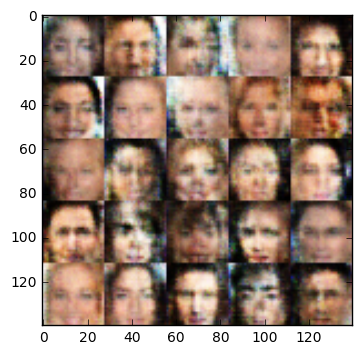

Epoch 1/1 Batch# 310... Discriminator Loss: 1.4796... Generator Loss: 0.5769
Epoch 1/1 Batch# 320... Discriminator Loss: 1.4612... Generator Loss: 0.6348
Epoch 1/1 Batch# 330... Discriminator Loss: 1.5012... Generator Loss: 0.5792
Epoch 1/1 Batch# 340... Discriminator Loss: 1.5335... Generator Loss: 0.6374
Epoch 1/1 Batch# 350... Discriminator Loss: 1.5649... Generator Loss: 0.5257
Epoch 1/1 Batch# 360... Discriminator Loss: 1.5466... Generator Loss: 0.6233
Epoch 1/1 Batch# 370... Discriminator Loss: 1.3760... Generator Loss: 0.6939
Epoch 1/1 Batch# 380... Discriminator Loss: 1.4562... Generator Loss: 0.6689
Epoch 1/1 Batch# 390... Discriminator Loss: 1.4274... Generator Loss: 0.6879
Epoch 1/1 Batch# 400... Discriminator Loss: 1.4567... Generator Loss: 0.7051


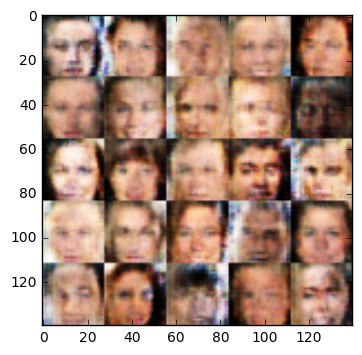

Epoch 1/1 Batch# 410... Discriminator Loss: 1.3973... Generator Loss: 0.6203
Epoch 1/1 Batch# 420... Discriminator Loss: 1.5719... Generator Loss: 0.5543
Epoch 1/1 Batch# 430... Discriminator Loss: 1.4858... Generator Loss: 0.6559
Epoch 1/1 Batch# 440... Discriminator Loss: 1.4955... Generator Loss: 0.5945
Epoch 1/1 Batch# 450... Discriminator Loss: 1.3435... Generator Loss: 0.7275
Epoch 1/1 Batch# 460... Discriminator Loss: 1.4204... Generator Loss: 0.6802
Epoch 1/1 Batch# 470... Discriminator Loss: 1.4562... Generator Loss: 0.6313
Epoch 1/1 Batch# 480... Discriminator Loss: 1.4417... Generator Loss: 0.6612
Epoch 1/1 Batch# 490... Discriminator Loss: 1.4284... Generator Loss: 0.6954
Epoch 1/1 Batch# 500... Discriminator Loss: 1.4040... Generator Loss: 0.7558


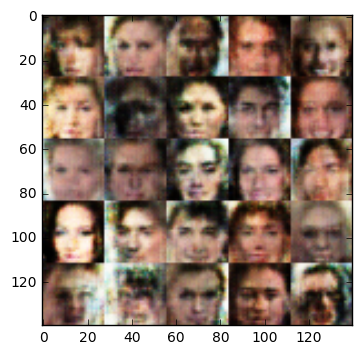

Epoch 1/1 Batch# 510... Discriminator Loss: 1.4707... Generator Loss: 0.6513
Epoch 1/1 Batch# 520... Discriminator Loss: 1.4787... Generator Loss: 0.6591
Epoch 1/1 Batch# 530... Discriminator Loss: 1.4713... Generator Loss: 0.5937
Epoch 1/1 Batch# 540... Discriminator Loss: 1.5077... Generator Loss: 0.6225
Epoch 1/1 Batch# 550... Discriminator Loss: 1.3997... Generator Loss: 0.6634
Epoch 1/1 Batch# 560... Discriminator Loss: 1.4513... Generator Loss: 0.6668
Epoch 1/1 Batch# 570... Discriminator Loss: 1.4167... Generator Loss: 0.5993
Epoch 1/1 Batch# 580... Discriminator Loss: 1.4598... Generator Loss: 0.6521
Epoch 1/1 Batch# 590... Discriminator Loss: 1.3799... Generator Loss: 0.6811
Epoch 1/1 Batch# 600... Discriminator Loss: 1.4917... Generator Loss: 0.6638


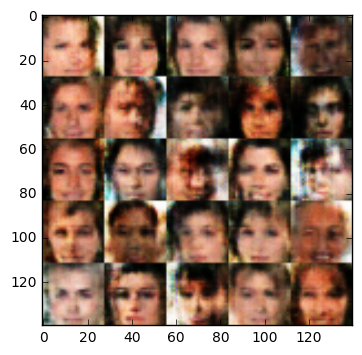

Epoch 1/1 Batch# 610... Discriminator Loss: 1.4439... Generator Loss: 0.6436
Epoch 1/1 Batch# 620... Discriminator Loss: 1.4873... Generator Loss: 0.6209
Epoch 1/1 Batch# 630... Discriminator Loss: 1.4963... Generator Loss: 0.6269
Epoch 1/1 Batch# 640... Discriminator Loss: 1.5656... Generator Loss: 0.5458
Epoch 1/1 Batch# 650... Discriminator Loss: 1.4323... Generator Loss: 0.5838
Epoch 1/1 Batch# 660... Discriminator Loss: 1.4321... Generator Loss: 0.6345
Epoch 1/1 Batch# 670... Discriminator Loss: 1.4977... Generator Loss: 0.6051
Epoch 1/1 Batch# 680... Discriminator Loss: 1.4650... Generator Loss: 0.5975
Epoch 1/1 Batch# 690... Discriminator Loss: 1.4525... Generator Loss: 0.6878
Epoch 1/1 Batch# 700... Discriminator Loss: 1.3985... Generator Loss: 0.7672


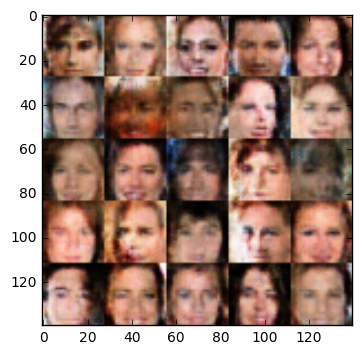

Epoch 1/1 Batch# 710... Discriminator Loss: 1.3677... Generator Loss: 0.6404
Epoch 1/1 Batch# 720... Discriminator Loss: 1.3858... Generator Loss: 0.6778
Epoch 1/1 Batch# 730... Discriminator Loss: 1.4367... Generator Loss: 0.6698
Epoch 1/1 Batch# 740... Discriminator Loss: 1.4583... Generator Loss: 0.6548
Epoch 1/1 Batch# 750... Discriminator Loss: 1.4959... Generator Loss: 0.5466
Epoch 1/1 Batch# 760... Discriminator Loss: 1.3700... Generator Loss: 0.6941
Epoch 1/1 Batch# 770... Discriminator Loss: 1.4581... Generator Loss: 0.5652
Epoch 1/1 Batch# 780... Discriminator Loss: 1.4853... Generator Loss: 0.6309
Epoch 1/1 Batch# 790... Discriminator Loss: 1.5356... Generator Loss: 0.6686
Epoch 1/1 Batch# 800... Discriminator Loss: 1.4265... Generator Loss: 0.6585


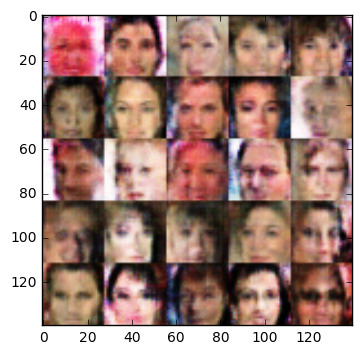

Epoch 1/1 Batch# 810... Discriminator Loss: 1.4306... Generator Loss: 0.6479
Epoch 1/1 Batch# 820... Discriminator Loss: 1.5207... Generator Loss: 0.5409
Epoch 1/1 Batch# 830... Discriminator Loss: 1.4135... Generator Loss: 0.7421
Epoch 1/1 Batch# 840... Discriminator Loss: 1.4309... Generator Loss: 0.5955
Epoch 1/1 Batch# 850... Discriminator Loss: 1.4550... Generator Loss: 0.6052
Epoch 1/1 Batch# 860... Discriminator Loss: 1.4477... Generator Loss: 0.6434
Epoch 1/1 Batch# 870... Discriminator Loss: 1.4616... Generator Loss: 0.6053
Epoch 1/1 Batch# 880... Discriminator Loss: 1.4420... Generator Loss: 0.5863
Epoch 1/1 Batch# 890... Discriminator Loss: 1.3687... Generator Loss: 0.7131
Epoch 1/1 Batch# 900... Discriminator Loss: 1.4171... Generator Loss: 0.6746


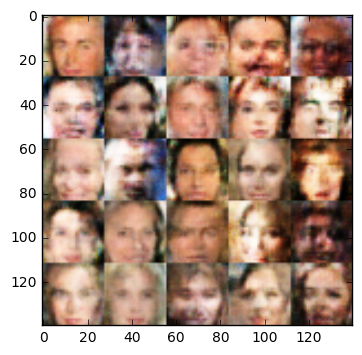

Epoch 1/1 Batch# 910... Discriminator Loss: 1.3547... Generator Loss: 0.7434
Epoch 1/1 Batch# 920... Discriminator Loss: 1.4744... Generator Loss: 0.5386
Epoch 1/1 Batch# 930... Discriminator Loss: 1.4890... Generator Loss: 0.6276
Epoch 1/1 Batch# 940... Discriminator Loss: 1.4298... Generator Loss: 0.6642
Epoch 1/1 Batch# 950... Discriminator Loss: 1.5366... Generator Loss: 0.6111
Epoch 1/1 Batch# 960... Discriminator Loss: 1.4218... Generator Loss: 0.6391
Epoch 1/1 Batch# 970... Discriminator Loss: 1.4629... Generator Loss: 0.5618
Epoch 1/1 Batch# 980... Discriminator Loss: 1.5220... Generator Loss: 0.5541
Epoch 1/1 Batch# 990... Discriminator Loss: 1.4418... Generator Loss: 0.6977
Epoch 1/1 Batch# 1000... Discriminator Loss: 1.4930... Generator Loss: 0.5890


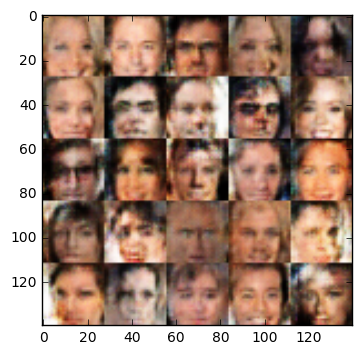

Epoch 1/1 Batch# 1010... Discriminator Loss: 1.3467... Generator Loss: 0.7781
Epoch 1/1 Batch# 1020... Discriminator Loss: 1.5519... Generator Loss: 0.4852
Epoch 1/1 Batch# 1030... Discriminator Loss: 1.5290... Generator Loss: 0.5380
Epoch 1/1 Batch# 1040... Discriminator Loss: 1.4669... Generator Loss: 0.6149
Epoch 1/1 Batch# 1050... Discriminator Loss: 1.4506... Generator Loss: 0.6629
Epoch 1/1 Batch# 1060... Discriminator Loss: 1.4627... Generator Loss: 0.6659
Epoch 1/1 Batch# 1070... Discriminator Loss: 1.4016... Generator Loss: 0.6466
Epoch 1/1 Batch# 1080... Discriminator Loss: 1.4074... Generator Loss: 0.6645
Epoch 1/1 Batch# 1090... Discriminator Loss: 1.4927... Generator Loss: 0.5946
Epoch 1/1 Batch# 1100... Discriminator Loss: 1.4710... Generator Loss: 0.6151


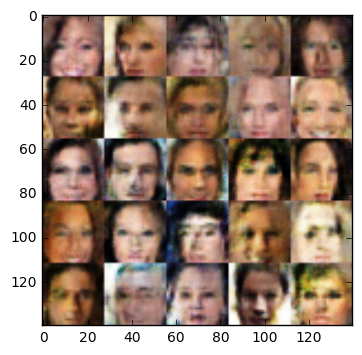

Epoch 1/1 Batch# 1110... Discriminator Loss: 1.4286... Generator Loss: 0.6623
Epoch 1/1 Batch# 1120... Discriminator Loss: 1.5183... Generator Loss: 0.5809
Epoch 1/1 Batch# 1130... Discriminator Loss: 1.4640... Generator Loss: 0.6333
Epoch 1/1 Batch# 1140... Discriminator Loss: 1.5288... Generator Loss: 0.5466
Epoch 1/1 Batch# 1150... Discriminator Loss: 1.4573... Generator Loss: 0.6159
Epoch 1/1 Batch# 1160... Discriminator Loss: 1.4686... Generator Loss: 0.6196
Epoch 1/1 Batch# 1170... Discriminator Loss: 1.5323... Generator Loss: 0.6339
Epoch 1/1 Batch# 1180... Discriminator Loss: 1.3971... Generator Loss: 0.5606
Epoch 1/1 Batch# 1190... Discriminator Loss: 1.4679... Generator Loss: 0.6105
Epoch 1/1 Batch# 1200... Discriminator Loss: 1.5191... Generator Loss: 0.5018


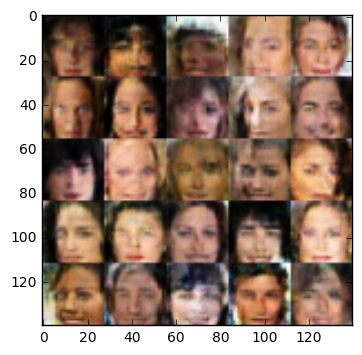

Epoch 1/1 Batch# 1210... Discriminator Loss: 1.4790... Generator Loss: 0.6108
Epoch 1/1 Batch# 1220... Discriminator Loss: 1.3916... Generator Loss: 0.6993
Epoch 1/1 Batch# 1230... Discriminator Loss: 1.4323... Generator Loss: 0.6212
Epoch 1/1 Batch# 1240... Discriminator Loss: 1.5508... Generator Loss: 0.5708
Epoch 1/1 Batch# 1250... Discriminator Loss: 1.4394... Generator Loss: 0.7069
Epoch 1/1 Batch# 1260... Discriminator Loss: 1.4696... Generator Loss: 0.5980
Epoch 1/1 Batch# 1270... Discriminator Loss: 1.4711... Generator Loss: 0.5439
Epoch 1/1 Batch# 1280... Discriminator Loss: 1.4672... Generator Loss: 0.6513
Epoch 1/1 Batch# 1290... Discriminator Loss: 1.4392... Generator Loss: 0.5966
Epoch 1/1 Batch# 1300... Discriminator Loss: 1.5370... Generator Loss: 0.5321


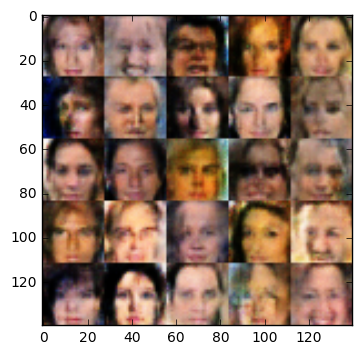

Epoch 1/1 Batch# 1310... Discriminator Loss: 1.4343... Generator Loss: 0.6544
Epoch 1/1 Batch# 1320... Discriminator Loss: 1.4491... Generator Loss: 0.6157
Epoch 1/1 Batch# 1330... Discriminator Loss: 1.4237... Generator Loss: 0.5790
Epoch 1/1 Batch# 1340... Discriminator Loss: 1.4767... Generator Loss: 0.5763
Epoch 1/1 Batch# 1350... Discriminator Loss: 1.4218... Generator Loss: 0.6057
Epoch 1/1 Batch# 1360... Discriminator Loss: 1.5296... Generator Loss: 0.5169
Epoch 1/1 Batch# 1370... Discriminator Loss: 1.4648... Generator Loss: 0.6333
Epoch 1/1 Batch# 1380... Discriminator Loss: 1.4486... Generator Loss: 0.6582
Epoch 1/1 Batch# 1390... Discriminator Loss: 1.4874... Generator Loss: 0.5851
Epoch 1/1 Batch# 1400... Discriminator Loss: 1.4388... Generator Loss: 0.6528


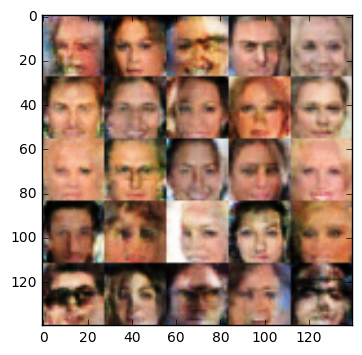

Epoch 1/1 Batch# 1410... Discriminator Loss: 1.4921... Generator Loss: 0.5995
Epoch 1/1 Batch# 1420... Discriminator Loss: 1.4505... Generator Loss: 0.6077
Epoch 1/1 Batch# 1430... Discriminator Loss: 1.4392... Generator Loss: 0.6681
Epoch 1/1 Batch# 1440... Discriminator Loss: 1.2661... Generator Loss: 0.7524
Epoch 1/1 Batch# 1450... Discriminator Loss: 1.4897... Generator Loss: 0.5665
Epoch 1/1 Batch# 1460... Discriminator Loss: 1.4078... Generator Loss: 0.6712
Epoch 1/1 Batch# 1470... Discriminator Loss: 1.4792... Generator Loss: 0.6078
Epoch 1/1 Batch# 1480... Discriminator Loss: 1.3937... Generator Loss: 0.6592
Epoch 1/1 Batch# 1490... Discriminator Loss: 1.4678... Generator Loss: 0.6218
Epoch 1/1 Batch# 1500... Discriminator Loss: 1.5558... Generator Loss: 0.5510


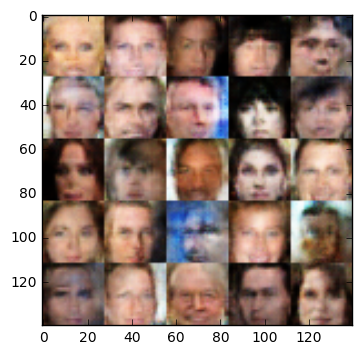

Epoch 1/1 Batch# 1510... Discriminator Loss: 1.3390... Generator Loss: 0.7022
Epoch 1/1 Batch# 1520... Discriminator Loss: 1.4680... Generator Loss: 0.5240
Epoch 1/1 Batch# 1530... Discriminator Loss: 1.4090... Generator Loss: 0.6723
Epoch 1/1 Batch# 1540... Discriminator Loss: 1.6016... Generator Loss: 0.4716
Epoch 1/1 Batch# 1550... Discriminator Loss: 1.4016... Generator Loss: 0.6633
Epoch 1/1 Batch# 1560... Discriminator Loss: 1.3834... Generator Loss: 0.7106
Epoch 1/1 Batch# 1570... Discriminator Loss: 1.3929... Generator Loss: 0.6804
Epoch 1/1 Batch# 1580... Discriminator Loss: 1.4619... Generator Loss: 0.5979


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.